In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm 


In [3]:
!pip3.11 install optuna

In [4]:
import optuna

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 06: Redes neurais

**1.** O código abaixo baixa e carrega o banco de dados CIFAR10, que contém diversas imagens RGB de 10 classes distintas. Além disso, os dados já estão separados em um objeto que provê batches de treino, teste e validação. Também provemos um exemplo de como definir um modelo em pytorch (você é livre para modifica-lo e facilitar sua vida), bem como um exemplo de como carregar batches. Treine uma CNN para resolver o problema --- fazendo uma busca de hiper-parâmetros razoável baseada no erro de validação. Consulte a documentação do pytorch para entender o que cada função na definição da CNN faz. Reporte os resultados do modelo escolhido no conjunto de teste, bem como suas curvas de aprendizado. Além disso, mostre como os dados de entrada são transformados ao longo das camadas (plote as figuras intermerdiárias para alguns inputs da sua escolha) e comente. 

cuda:0
Files already downloaded and verified
Files already downloaded and verified


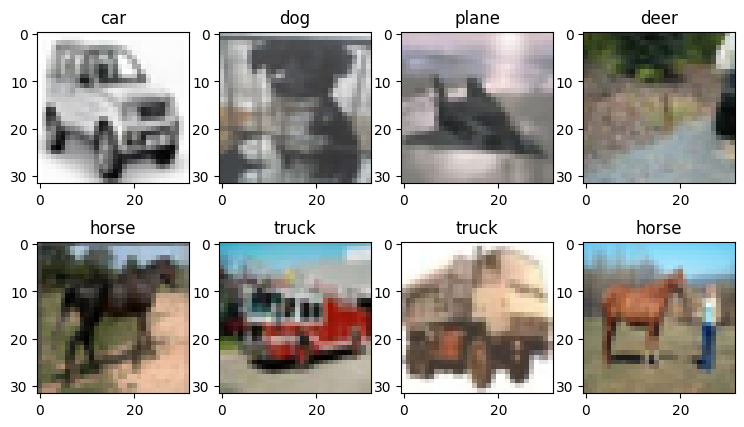

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# The batch size
batch_size = 2048 

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=transform_train,
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True,
    transform=transform_test
)

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

n_img = 8

f, ax = plt.subplots(2, 4, figsize=(9,5))
dataiter = iter(test_loader)
images, labels = next(dataiter)

for i in range(n_img):
    npimg = images[i]/2 + 0.5
    npimg = npimg.numpy()
    ax[i%2,i//2].imshow(np.transpose(npimg, (1, 2, 0)))
    ax[i%2,i//2].set_title(classes[labels[i]])



In [6]:
from torch.utils.data import random_split

# Split the train dataset into train and validation subsets
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_subset, val_subset = random_split(train_set, [train_size, val_size])

# Create data loaders for train and validation subsets
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=4, shuffle=True)


In [36]:
train_subset[0][0].size()

torch.Size([3, 32, 32])

In [55]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.LazyLinear(120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnn = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.01)

epochs = 100

for epoch in range(epochs):
    clear_output(wait=True)
    print('Epoch {}/{}'.format(epoch+1, epochs))
    for batch in train_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
    
        optimizer_cnn.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_cnn.step()

with torch.no_grad():
    print('Evaluating the model on the test set...')
    correct = 0
    total = 0
    i = 0
    for batch in test_loader:
        clear_output(wait=True)
        print('Test' + str(i), flush=True)
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        i += 1
    
    print('Accuracy: {} %'.format(100 * correct / total))

# for epoch in range(1):  # loop over the dataset multiple times
#     running_loss = 0.0
#     aux = 0
#     for data in train_loader:
#         if aux == 0 and epoch == 0:
#             # train on a small batch
#             cnn.train() 
#         aux += 1


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100


In [50]:
class CNN(nn.Module):
  def __init__(self, num_filters1, num_filters2, num_filters3, kernel_size1, kernel_size2, kernel_size3, stride1, stride2, stride3, padding1, padding2, padding3, dropout_rate):
    super().__init__()
    self.conv1 = nn.Conv2d(3, num_filters1, kernel_size1, stride=stride1, padding=padding1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(num_filters1, num_filters2, kernel_size2, stride=stride2, padding=padding2)
    self.conv3 = nn.Conv2d(num_filters2, num_filters3, kernel_size3, stride=stride3, padding=padding3)
    self.fc1 = nn.LazyLinear(120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x

2

def objective(trial):
  # Define the hyperparameters to tune
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  num_filters1 = trial.suggest_int("num_filters1", 4, 16)
  num_filters2 = trial.suggest_int("num_filters2", 8, 32)
  num_filters3 = trial.suggest_int("num_filters3", 16, 64)
  kernel_size1 = 1 # trial.suggest_int("kernel_size1", 3, 7)
  kernel_size2 = 1 # trial.suggest_int("kernel_size2", 3, 7)
  kernel_size3 = 1 # trial.suggest_int("kernel_size3", 3, 7)
  stride1 = 2 # trial.suggest_int("stride1", 1, 3)
  stride2 = 2 # trial.suggest_int("stride2", 1, 3)
  stride3 = 2 # trial.suggest_int("stride3", 1, 3)
  padding1 = 0 # trial.suggest_int("padding1", 0, 3)
  padding2 = 0 #trial.suggest_int("padding2", 0, 3)
  padding3 = 0 #trial.suggest_int("padding3", 0, 3)

  dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)

  # Create a new CNN with the tuned hyperparameters
  cnn = CNN(num_filters1, num_filters2, num_filters3, kernel_size1, kernel_size2, kernel_size3, stride1, stride2, stride3, padding1, padding2, padding3, dropout_rate).to(device)

  # Define the optimizer and the criterion
  optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()

  # Train the CNN for one epoch
  cnn.train()
  for batch in train_loader:
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    optimizer_cnn.zero_grad()
    outputs = cnn(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer_cnn.step()

  # Evaluate the CNN on the validation set
  cnn.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for batch in val_loader:
      images, labels = batch
      images = images.to(device)
      labels = labels.to(device)
      outputs = cnn(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  
  # Return the accuracy as the objective value to maximize
  accuracy = correct / total
  return accuracy



In [51]:
# Create a study and run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

# Print the best hyperparameters and the best accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)


[I 2023-05-29 12:16:05,790] A new study created in memory with name: no-name-f24af766-23ea-42bd-a5d5-792d171390f0
[W 2023-05-29 12:16:06,133] Trial 0 failed with parameters: {'lr': 0.00024815574041606723, 'num_filters1': 9, 'num_filters2': 13, 'num_filters3': 64, 'dropout_rate': 0.13012411240535532} because of the following error: RuntimeError('Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small').
Traceback (most recent call last):
  File "c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_3380\2629899152.py", line 58, in objective
    outputs = cnn(images)
              ^^^^^^^^^^^
  File "c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
    

RuntimeError: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small

In [22]:
class CNN(nn.Module):
  def __init__(self, num_filters1, num_filters2, dropout_rate):
    super().__init__()
    self.conv1 = nn.Conv2d(3, num_filters1, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(num_filters1, num_filters2, 5)
    self.fc1 = nn.LazyLinear(120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x

def objective(trial):
  # Define the hyperparameters to tune
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  num_filters1 = trial.suggest_int("num_filters1", 4, 16)
  num_filters2 = trial.suggest_int("num_filters2", 8, 32)
  dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)

  # Create a new CNN with the tuned hyperparameters
  cnn = CNN(num_filters1, num_filters2, dropout_rate).to(device)

  # Define the optimizer and the criterion
  optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()

  # Train the CNN for one epoch
  cnn.train()
  for batch in train_loader:
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    optimizer_cnn.zero_grad()
    outputs = cnn(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer_cnn.step()

  # Evaluate the CNN on the validation set
  cnn.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for batch in val_loader:
      images, labels = batch
      images = images.to(device)
      labels = labels.to(device)
      outputs = cnn(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  
  # Return the accuracy as the objective value to maximize
  accuracy = correct / total
  return accuracy


In [23]:
# Create a study and run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and the best accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)


[I 2023-05-21 10:37:55,820] A new study created in memory with name: no-name-d8d2ee6d-781a-4d6f-86e1-fc803ff0fea6
[I 2023-05-21 10:38:36,733] Trial 0 finished with value: 0.2525 and parameters: {'lr': 0.0024429442160927416, 'num_filters1': 14, 'num_filters2': 17, 'dropout_rate': 0.4639603899256783}. Best is trial 0 with value: 0.2525.
[I 2023-05-21 10:39:20,839] Trial 1 finished with value: 0.2822 and parameters: {'lr': 1.3412562094438e-05, 'num_filters1': 12, 'num_filters2': 17, 'dropout_rate': 0.14667606739708933}. Best is trial 1 with value: 0.2822.
[I 2023-05-21 10:40:03,643] Trial 2 finished with value: 0.4722 and parameters: {'lr': 0.0016269383236623956, 'num_filters1': 8, 'num_filters2': 26, 'dropout_rate': 0.032252763253001415}. Best is trial 2 with value: 0.4722.
[I 2023-05-21 10:40:44,085] Trial 3 finished with value: 0.4264 and parameters: {'lr': 0.0011529266142224794, 'num_filters1': 15, 'num_filters2': 32, 'dropout_rate': 0.3303930818838707}. Best is trial 2 with value: 0.

Best hyperparameters: {'lr': 0.000543977010534472, 'num_filters1': 15, 'num_filters2': 27, 'dropout_rate': 0.030691169281183144}
Best accuracy: 0.5475


In [29]:
# Retrieve the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

num_filters1, num_filters2, dropout_rate = best_params['num_filters1'], best_params['num_filters2'], best_params['dropout_rate']

# Create a new CNN with the best hyperparameters
best_cnn = CNN(num_filters1=num_filters1,num_filters2=num_filters2,dropout_rate=dropout_rate).to(device)

lr= best_params['lr']
optimizer_cnn = torch.optim.Adam(best_cnn.parameters(), lr=lr)

epochs = 64

for epoch in range(epochs):
    for batch in train_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
    
        optimizer_cnn.zero_grad()
        outputs = best_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_cnn.step()

with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy: {} %'.format(100 * correct / total))


Best hyperparameters: {'lr': 0.000543977010534472, 'num_filters1': 15, 'num_filters2': 27, 'dropout_rate': 0.030691169281183144}


c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


RuntimeError: Given groups=1, weight of size [24, 6, 5, 5], expected input[2048, 32, 14, 14] to have 6 channels, but got 32 channels instead

# Exercício de "papel e caneta"

**1.** Na aula discutimos como CNNs podem ser vistas como casos especiais de MLPs. Com isso em mente, mostre que i) camadas convolucionais podem ser escritas como uma transformação linear seguida por uma transformação não linear; e ii) camadas de pooling de média ou soma podem ser escritas como transformações lineares. 

Matemáticamente, uma camada convolucional pode ser escrita como:

$$S(i,j) = (K \ast I)(i,j) = \sum_m \sum_n I(i-m,j-n) K(m,n)$$

Onde $I$ é a imagem de entrada, $K$ é o kernel da convolução e $S$ é a imagem de saída.

Para ser uma transformação linear, a operação de convolução deve satisfazer a propriedade de aditividade e homogeneidade. A propriedade de aditividade é satisfeita pois:

$$S(i,j) + S'(i,j) = \sum_m \sum_n I(i-m,j-n) K(m,n) + \sum_m \sum_n I'(i-m,j-n) K(m,n)$$

$$S(i,j) + S'(i,j) = \sum_m \sum_n [I(i-m,j-n) + I'(i-m,j-n)] K(m,n)$$

Já a propriedade de homogeneidade é satisfeita pois:

$$\alpha S(i,j) = \alpha \sum_m \sum_n I(i-m,j-n) K(m,n)$$

Então, a operação de convolução é uma transformação linear.

**2.** Criar modelos invariantes a transformações específicas das suas entradas é um tópico quente em machine learning. Por exemplo, suponha que queremos prever propriedades de um grafo $G$ de $n$ nós, com matriz de adjacência $A \in \{0,1\}^{n \times n}$ e em que cada nó $i=1,\ldots,n$ é anotado com um vetor de features $x_i \in \mathbb{R}^d$. Deixe ainda que $X = [x_1, \ldots, x_n]^\intercal$. Note também que um grafo com features de nó pode ser descrito como uma tupla $(X, A)$ sem perda de generalidade. Nesse caso, gostaríamos que nossa rede neural $f$ produzisse o mesmo output para grafos identicos (i.e., fosse invariante a isomorfismo). Dizemos que dois grafos $G=(X, A)$ e $G^\prime=(X^\prime, A^\prime)$ são isomorfos se existe uma matriz de permutação $P \in \{0,1\}^{n \times n} : \forall_i \sum_i P_{ij} = 1, \forall_j P_{ij} = 1 $ tal que $X^\prime = P X$ e $A^\prime = P A P^\intercal$.

Existem uma classe de redes neurais desenhadas especialmente para serem invariantes a isomorfismo: graph neural networks (GNNs). A mais famosa dessas redes é chamada graph convolutional network (GCN). O funcionamento de uma GCN de $L$ camadas para classificação de propriedades de grafos pode ser descrito como:
\begin{align}
&\hat{y} = \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n H^{(L)}_{i:}\right)\\
&H^{(\ell)} = \textrm{ReLU}(\tilde{A}H^{(\ell-1)} W^{(\ell)}) \qquad \forall \ell=1,\ldots,L\\
&H^{(0)} = X
\end{align}
onde $W^{(\ell)} \in \mathbb{R^{d_{\ell-1} \times d_{\ell}}}$ são matrizes de peso, com $d_0 = d$ e $d_L$ sendo o número de classes do nosso problema de classificação. Além disse, $\tilde{A} = D^{-1/2}(A + I)D^{-1/2}$ onde $D$ é uma matriz diagonal com $D_{ii}$ contendo o grau do nó $i$.

Prove que a GCN descrita acima produz o mesmo valor para qualquer grafo isomorfo à $G=(X, A)$.

Se você estiver interessado em aprender o básico sobre GNNs, esse vídeo é um bom começo: https://www.youtube.com/watch?v=8owQBFAHw7E (não é necessário para resolver essa questão).

Dica: Mostre antes que se $P$ é uma matriz de permutação $P^\intercal P = I$.